# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). The autoencoder is a vector-quantized variational autoencoder from the paper [Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Vector-Quantized Variational Autoencoders](https://keras.io/examples/generative/vq_vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

In [153]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator

In [216]:
image_size = 128
channels = 3
color_mode = 'rgb'

# Autoencoder.
dropout = 0.1
autoencoder_batch_size = 32
autoencoder_epochs = 100
autoencoder_widths = [32, 64, 96]
autoencoder_block_depth = 2
latent_size = int(image_size / 2**len(autoencoder_widths))
beta_slope = 0.01
beta_period = 1000
max_beta = 10.0
min_beta = 0.0

# Diffusion.
diffusion_batch_size = 64
diffusion_epochs = 100
min_signal_rate = 0.02
max_signal_rate = 0.95
embedding_dims = 32
embedding_max_frequency = 1000.0
diffusion_widths = [32, 64, 96]
diffusion_block_depth = 2

In [217]:
def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
dogs = idg.flow_from_directory(
    #'../heightmaps/uncorrupted_split_heightmaps_second_pass/',
    '../stanford_dogs/images/Images/',
    target_size = (image_size, image_size), 
    batch_size = autoencoder_batch_size,
    color_mode = color_mode,
    classes = ['']
)

Found 20580 images belonging to 1 classes.


In [218]:
def plot_images(images):
    plt.figure(figsize = (50 * 3, 50))
    num_images = images.shape[0]
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')

    plt.tight_layout()
    plt.show()

In [219]:
plt.rcParams.update({'font.size': 12})
def plot_performance(history, epochs, metric):
    fig, ax = plt.subplots(1, 1)
    plt.title(metric)
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    
    x = list(range(1, epochs + 1))
    ty = history.history[metric]
    
    ax.plot(x, ty, label = 'Train')
    
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## Variational Autoencoder

In [220]:
def EncoderBlock(widths):
    def apply(x):
        for width in widths:
            if x.shape[0] == width:
                residual = x
            else:
                residual = layers.Conv2D(width, (1, 1))(x)
            x = layers.BatchNormalization()(x)
            for _ in range(autoencoder_block_depth):
                x = layers.Conv2D(width, (3, 3), activation='relu', padding='same')(x)
            x = layers.Add()([x, residual])
            x = layers.MaxPooling2D((2, 2), padding='same')(x)
        return x
    
    return apply

def DecoderBlock(widths):
    def apply(x):
        for width in widths:
            if x.shape[0] == width:
                residual = x
            else:
                residual = layers.Conv2D(width, (1, 1))(x)
            for _ in range(autoencoder_block_depth):
                x = layers.Conv2D(width, (3, 3), activation='relu', padding='same')(x)
            x = layers.Add()([x, residual])
            x = layers.UpSampling2D((2, 2))(x)
            
        x = layers.Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
        return x
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(z_mean.shape[1], z_mean.shape[2], channels))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [221]:
class BetaScheduler(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        if(self.model.beta_schedule_step == self.model.beta_period):
            pass
            #self.model.beta.assign(min_beta)
            #self.model.beta_schedule_step = 0
        if self.model.beta < max_beta:
            self.model.beta.assign(self.model.beta_slope * self.model.beta_schedule_step)
        if self.model.beta >= max_beta:
            self.model.beta.assign(max_beta)
        
        self.model.beta_schedule_step += 1
        return
    
    def on_epoch_end(self, epoch, logs=None):
        print(' - beta:', self.model.beta.numpy())
        return

In [222]:
class VAE(keras.Model):
    def __init__(self, widths, beta_slope, beta_period, encoder=None, decoder=None):
        super().__init__()
        self.encoder_widths = widths
        self.decoder_widths = list(reversed(widths))
        
        if encoder != None:
            self.encoder = encoder
        else:
            self.encoder = self.create_encoder()
            
        if decoder != None:
            self.decoder = decoder
        else:
            self.decoder = self.create_decoder()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.beta_schedule_step = 0
        self.beta = tf.Variable(0.0, trainable=False)
        self.beta_slope = beta_slope
        self.beta_period = beta_period
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock(self.encoder_widths)(input_image)
        z_mean = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(latent_size, latent_size, channels))
        decoded = DecoderBlock(self.decoder_widths)(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        data = data[0] # Get rid of labels.
        
        with tf.GradientTape() as tape:
            # Encoding/Decoding.
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # loss.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
                
            kl_loss = -self.beta * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data)
        return z
    
    def decode(self, data):
        x = self.decoder(data)
        return x

In [223]:
vae = VAE(autoencoder_widths, beta_slope, beta_period)
vae.compile(optimizer='adam')

In [224]:
vae_history = vae.fit(dogs, epochs=autoencoder_epochs, callbacks=[BetaScheduler()])
#vae_history = vae.fit(dogs, epochs=autoencoder_epochs)

Epoch 1/100
  5/644 [..............................] - ETA: 28s - loss: 1445.0181 - reconstruction_loss: 1230.3225 - kl_loss: 0.1383    WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0247s vs `on_train_batch_end` time: 0.0318s). Check your callbacks.


644/644 [==============================] - 31s 45ms/step - loss: 400.7296 - reconstruction_loss: 276.1496 - kl_loss: 61.3530
Epoch 2/100
644/644 [==============================] - 30s 47ms/step - loss: 363.7884 - reconstruction_loss: 270.9444 - kl_loss: 105.7812
Epoch 3/100
644/644 [==============================] - 29s 46ms/step - loss: 381.4148 - reconstruction_loss: 272.3725 - kl_loss: 108.7857
Epoch 4/100
644/644 [==============================] - 29s 44ms/step - loss: 378.7479 - reconstruction_loss: 268.9488 - kl_loss: 107.3224
Epoch 5/100
644/644 [==============================] - 28s 44ms/step - loss: 376.3638 - reconstruction_loss: 267.5328 - kl_loss: 107.4596
Epoch 6/100
644/644 [==============================] - 29s 45ms/step - loss: 371.8531 - reconstruction_loss: 264.3580 - kl_loss: 107.2918
Epoch 7/100
644/644 [==============================] - 29s 45ms/step - loss: 370.5676 - reconstruction_loss: 262.5934 - kl_loss: 107.8779
Epoch 8/100
644/644 [==========================

644/644 [==============================] - 29s 45ms/step - loss: 356.6975 - reconstruction_loss: 247.6324 - kl_loss: 109.0885
Epoch 32/100
644/644 [==============================] - 29s 45ms/step - loss: 357.9494 - reconstruction_loss: 248.1765 - kl_loss: 109.2746
Epoch 33/100
644/644 [==============================] - 28s 43ms/step - loss: 356.8264 - reconstruction_loss: 247.8546 - kl_loss: 108.8819
Epoch 34/100
644/644 [==============================] - 29s 45ms/step - loss: 356.6783 - reconstruction_loss: 247.6709 - kl_loss: 109.0555
Epoch 35/100
644/644 [==============================] - 29s 44ms/step - loss: 356.4887 - reconstruction_loss: 247.3301 - kl_loss: 109.2090
Epoch 36/100
644/644 [==============================] - 28s 43ms/step - loss: 357.4233 - reconstruction_loss: 247.7325 - kl_loss: 109.4400
Epoch 37/100
644/644 [==============================] - 28s 44ms/step - loss: 355.4139 - reconstruction_loss: 246.5836 - kl_loss: 108.8039
Epoch 38/100
644/644 [==================

644/644 [==============================] - 29s 45ms/step - loss: 354.1048 - reconstruction_loss: 244.6435 - kl_loss: 109.7204
Epoch 62/100
644/644 [==============================] - 29s 45ms/step - loss: 355.8691 - reconstruction_loss: 245.0309 - kl_loss: 109.3139
Epoch 63/100
644/644 [==============================] - 31s 47ms/step - loss: 353.6282 - reconstruction_loss: 244.7363 - kl_loss: 109.0692
Epoch 64/100
644/644 [==============================] - 29s 46ms/step - loss: 353.7940 - reconstruction_loss: 244.5162 - kl_loss: 108.8622
Epoch 65/100
644/644 [==============================] - 29s 46ms/step - loss: 354.0709 - reconstruction_loss: 245.0466 - kl_loss: 108.9193
Epoch 66/100
644/644 [==============================] - 28s 43ms/step - loss: 355.6336 - reconstruction_loss: 245.1974 - kl_loss: 109.4516
Epoch 67/100
644/644 [==============================] - 29s 45ms/step - loss: 354.9334 - reconstruction_loss: 244.9044 - kl_loss: 109.5239
Epoch 68/100
644/644 [==================

644/644 [==============================] - 29s 45ms/step - loss: 352.0301 - reconstruction_loss: 243.7887 - kl_loss: 108.8203
Epoch 92/100
644/644 [==============================] - 28s 44ms/step - loss: 350.5840 - reconstruction_loss: 243.7871 - kl_loss: 109.0923
Epoch 93/100
644/644 [==============================] - 29s 45ms/step - loss: 351.2927 - reconstruction_loss: 243.8347 - kl_loss: 108.4927
Epoch 94/100
644/644 [==============================] - 29s 44ms/step - loss: 352.6773 - reconstruction_loss: 243.8306 - kl_loss: 109.1203
Epoch 95/100
644/644 [==============================] - 30s 46ms/step - loss: 351.5379 - reconstruction_loss: 243.8903 - kl_loss: 109.0628
Epoch 96/100
644/644 [==============================] - 29s 45ms/step - loss: 352.6578 - reconstruction_loss: 243.3586 - kl_loss: 108.9604
Epoch 97/100
644/644 [==============================] - 28s 43ms/step - loss: 352.5258 - reconstruction_loss: 243.8397 - kl_loss: 109.2540
Epoch 98/100
644/644 [==================

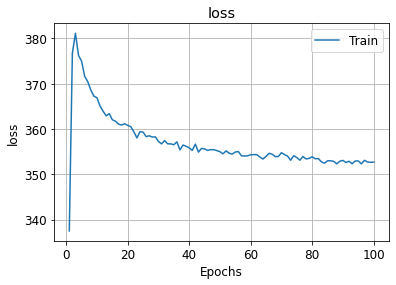

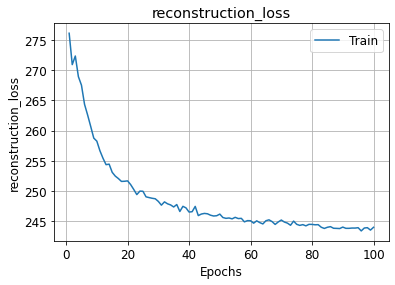

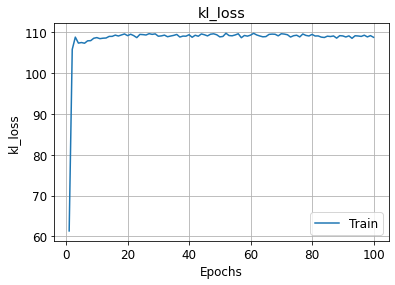

In [225]:
plot_performance(history=vae_history, epochs=autoencoder_epochs, metric='loss')
plot_performance(history=vae_history, epochs=autoencoder_epochs, metric='reconstruction_loss')
plot_performance(history=vae_history, epochs=autoencoder_epochs, metric='kl_loss')

In [103]:
vae.encoder.save('data/encoder13')
vae.decoder.save('data/decoder13')

INFO:tensorflow:Assets written to: data/encoder13\assets


INFO:tensorflow:Assets written to: data/encoder13\assets


INFO:tensorflow:Assets written to: data/decoder13\assets


INFO:tensorflow:Assets written to: data/decoder13\assets


In [226]:
dogs.reset()
encoded_images = vae.encode(dogs.next()[0])

for i in range(10):
    next_encoded = vae.encode(dogs.next()[0])
    encoded_images = tf.concat([encoded_images, next_encoded], axis=0)

decoded_images = vae.decode(encoded_images[0 : 10])

Encoded:


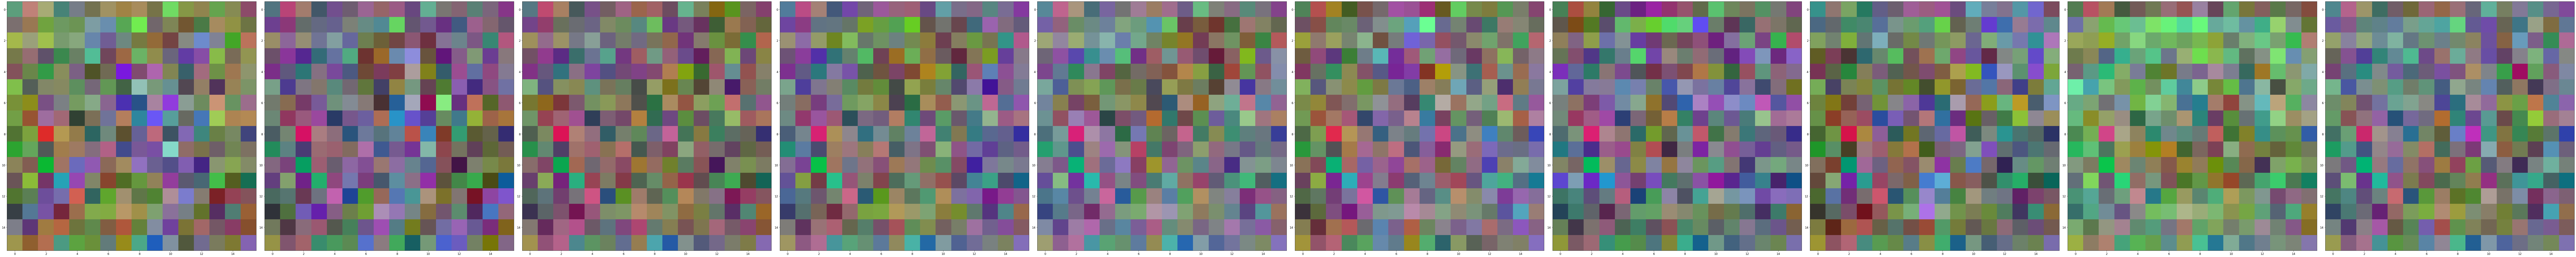

Decoded:


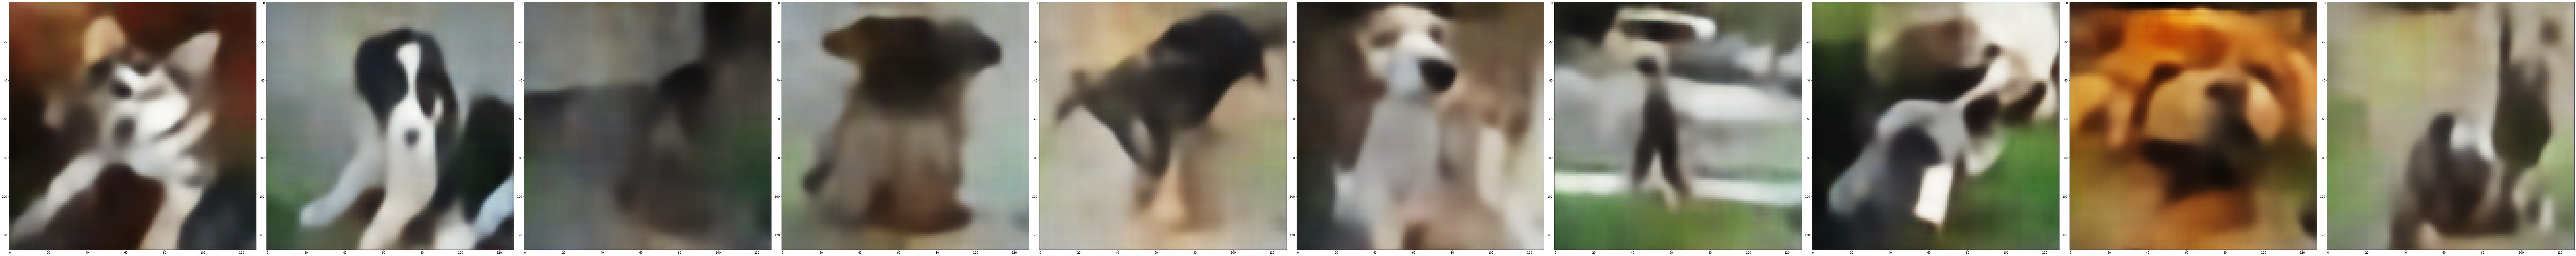

In [227]:
print('Encoded:')
encoded_display = encoded_images[0:10].numpy()
encoded_display -= np.min(encoded_display)
encoded_display /= np.max(encoded_display)
plot_images(encoded_display)

print('Decoded:')
decoded_images = vae.decode(encoded_images[0 : 10])
plot_images(decoded_images.numpy())

## Denoising U-Net

In [228]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [229]:
class DiffusionModel(keras.Model):
    def __init__(self, input_size, block_depth, widths):
        super().__init__()
        
        self.normalizer = layers.Normalization()
        self.model = self.create_model(input_size, widths, block_depth)
        self.input_size = input_size
    
    def create_model(self, input_size, widths, block_depth):
        noisy_input = keras.Input(shape=(input_size, input_size, channels))
        noise_variances = keras.Input(shape=(1, 1, 1))
        
        e = layers.Lambda(sinusoidal_embedding)(noise_variances)
        e = layers.UpSampling2D(size=input_size, interpolation='nearest')(e)
        
        x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
        x = layers.Concatenate()([x, e])
        
        skips = []
        for width in widths[:-1]:
            x = DownBlock(width, block_depth)([x, skips])
            
        for _ in range(block_depth):
            x = ResidualBlock(widths[-1])(x)
        
        for width in reversed(widths[:-1]):
            x = UpBlock(width, block_depth)([x, skips])
            
        x = layers.Conv2D(channels, kernel_size=1, kernel_initializer='zeros')(x)
        
        return keras.Model([noisy_input, noise_variances], x)
    
    def compile(self, **kwargs):
        super().compile(**kwargs)
        
        self.noise_loss_tracker = keras.metrics.Mean(name='n_loss')
        self.image_loss_tracker = keras.metrics.Mean(name='i_loss')
    
    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]
    
    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates
    
    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        pred_noises = self.model([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        return pred_noises, pred_images
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]    
        step_size = 1.0 / diffusion_steps
        
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            
        return pred_images
    
    def generate(self, num_images, diffusion_steps):
        initial_noise = tf.random.normal(shape=(num_images, self.input_size, self.input_size, channels))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        return generated_images
    
    def train_step(self, images):
        #images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(diffusion_batch_size, self.input_size, self.input_size, channels))
        
        diffusion_times = tf.random.uniform(
            shape=(diffusion_batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        
        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            
            noise_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(noises, pred_noises), axis=(1, 2)
                )
            )
            
            image_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(images, pred_images), axis=(1, 2)
                )
            )
            
        grads = tape.gradient(noise_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)
            
        return {m.name: m.result() for m in self.metrics}

In [230]:
end_index = int(encoded_images.shape[0] / diffusion_batch_size) * diffusion_batch_size
encoded_images = encoded_images[:end_index]

In [231]:
model = DiffusionModel(latent_size, diffusion_block_depth, diffusion_widths)
model.compile(optimizer='adam')

In [244]:
diffuser_history = model.fit(encoded_images, epochs=1000, batch_size=diffusion_batch_size)

Epoch 1/1000
5/5 [==============================] - 0s 34ms/step - n_loss: 6.7899 - i_loss: 51.0993
Epoch 2/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.2644 - i_loss: 46.2852
Epoch 3/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8418 - i_loss: 63.9660
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8182 - i_loss: 61.2374
Epoch 5/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.5911 - i_loss: 107.6387
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.0200 - i_loss: 107.2947
Epoch 7/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.0875 - i_loss: 93.9469
Epoch 8/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.2588 - i_loss: 67.7218
Epoch 9/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.6459 - i_loss: 66.6748
Epoch 10/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.5856 - i_loss: 61.2354
Epoch

5/5 [==============================] - 0s 12ms/step - n_loss: 7.3390 - i_loss: 59.0052
Epoch 83/1000
5/5 [==============================] - 0s 11ms/step - n_loss: 6.9574 - i_loss: 77.2791
Epoch 84/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.9473 - i_loss: 68.0822
Epoch 85/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7554 - i_loss: 61.9804
Epoch 86/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.4926 - i_loss: 67.1354
Epoch 87/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 7.4118 - i_loss: 52.0798
Epoch 88/1000
5/5 [==============================] - 0s 9ms/step - n_loss: 7.0502 - i_loss: 53.5062
Epoch 89/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.3554 - i_loss: 56.0978
Epoch 90/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.5861 - i_loss: 89.5064
Epoch 91/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8908 - i_loss: 71.9721
Epoch 92/

5/5 [==============================] - 0s 8ms/step - n_loss: 6.3819 - i_loss: 57.8702
Epoch 164/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.7359 - i_loss: 68.2425
Epoch 165/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.8979 - i_loss: 57.6119
Epoch 166/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.9484 - i_loss: 68.0157
Epoch 167/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.6796 - i_loss: 60.3251
Epoch 168/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8470 - i_loss: 55.4501
Epoch 169/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.5562 - i_loss: 68.5069
Epoch 170/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8099 - i_loss: 73.4847
Epoch 171/1000
5/5 [==============================] - 0s 9ms/step - n_loss: 6.4111 - i_loss: 73.6785
Epoch 172/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7992 - i_loss: 53.5843
E

Epoch 244/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7913 - i_loss: 61.9905
Epoch 245/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.7100 - i_loss: 50.3977
Epoch 246/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.9595 - i_loss: 62.0593
Epoch 247/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8279 - i_loss: 50.7021
Epoch 248/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.3566 - i_loss: 51.8116
Epoch 249/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.3095 - i_loss: 58.9940
Epoch 250/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4863 - i_loss: 55.8431
Epoch 251/1000
5/5 [==============================] - 0s 7ms/step - n_loss: 6.8578 - i_loss: 53.4034
Epoch 252/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.7380 - i_loss: 58.7700
Epoch 253/1000
5/5 [==============================] - 0s 10ms/step - n_loss: 6.4752 - i

5/5 [==============================] - 0s 8ms/step - n_loss: 6.8773 - i_loss: 48.8809
Epoch 325/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.8854 - i_loss: 76.8395
Epoch 326/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.8676 - i_loss: 65.8848
Epoch 327/1000
5/5 [==============================] - 0s 4ms/step - n_loss: 7.3066 - i_loss: 62.4325
Epoch 328/1000
5/5 [==============================] - 0s 16ms/step - n_loss: 7.2115 - i_loss: 57.0999
Epoch 329/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.1335 - i_loss: 101.7992
Epoch 330/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 8.4409 - i_loss: 65.0572
Epoch 331/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8315 - i_loss: 90.6013
Epoch 332/1000
5/5 [==============================] - 0s 9ms/step - n_loss: 7.3584 - i_loss: 62.1774
Epoch 333/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7118 - i_loss: 81.4124
Ep

5/5 [==============================] - 0s 8ms/step - n_loss: 6.3114 - i_loss: 60.7811
Epoch 405/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4034 - i_loss: 59.4826
Epoch 406/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.4623 - i_loss: 50.4073
Epoch 407/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.1643 - i_loss: 65.0525
Epoch 408/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.5694 - i_loss: 52.2182
Epoch 409/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4814 - i_loss: 58.4286
Epoch 410/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.2575 - i_loss: 57.2134
Epoch 411/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.2331 - i_loss: 55.3577
Epoch 412/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4030 - i_loss: 61.0405
Epoch 413/1000
5/5 [==============================] - 0s 9ms/step - n_loss: 6.8045 - i_loss: 69.0577
Epo

Epoch 485/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.7664 - i_loss: 93.9765
Epoch 486/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.0178 - i_loss: 70.7254
Epoch 487/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.6856 - i_loss: 58.8572
Epoch 488/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.6936 - i_loss: 69.2086
Epoch 489/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.5413 - i_loss: 60.5013
Epoch 490/1000
5/5 [==============================] - 0s 9ms/step - n_loss: 6.1184 - i_loss: 75.7680
Epoch 491/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.6152 - i_loss: 59.4969
Epoch 492/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8829 - i_loss: 71.4807
Epoch 493/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.4907 - i_loss: 69.6388
Epoch 494/1000
5/5 [==============================] - 0s 16ms/step - n_loss: 7.1562 - i_l

5/5 [==============================] - 0s 12ms/step - n_loss: 6.6337 - i_loss: 90.4272
Epoch 566/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.4295 - i_loss: 51.2366
Epoch 567/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.7193 - i_loss: 54.7292
Epoch 568/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.2721 - i_loss: 65.9875
Epoch 569/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4656 - i_loss: 58.8202
Epoch 570/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.0378 - i_loss: 69.6443
Epoch 571/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.6142 - i_loss: 54.7050
Epoch 572/1000
5/5 [==============================] - 0s 9ms/step - n_loss: 6.5567 - i_loss: 48.6822
Epoch 573/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 5.9560 - i_loss: 62.1503
Epoch 574/1000
5/5 [==============================] - 0s 10ms/step - n_loss: 6.1454 - i_loss: 56.1622
E

Epoch 646/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.3194 - i_loss: 80.7315
Epoch 647/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.5181 - i_loss: 62.6144
Epoch 648/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.1466 - i_loss: 68.5729
Epoch 649/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.5795 - i_loss: 51.8326
Epoch 650/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.1663 - i_loss: 64.4631
Epoch 651/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.5017 - i_loss: 70.7645
Epoch 652/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4935 - i_loss: 72.3018
Epoch 653/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.0685 - i_loss: 66.6960
Epoch 654/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4522 - i_loss: 64.4462
Epoch 655/1000
5/5 [==============================] - 0s 16ms/step - n_loss: 6.5528 - i_l

5/5 [==============================] - 0s 12ms/step - n_loss: 7.0447 - i_loss: 65.2607
Epoch 727/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.6450 - i_loss: 73.1538
Epoch 728/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 7.2449 - i_loss: 62.4873
Epoch 729/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7580 - i_loss: 60.5775
Epoch 730/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.8210 - i_loss: 60.4838
Epoch 731/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4296 - i_loss: 55.8805
Epoch 732/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.8155 - i_loss: 55.4422
Epoch 733/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4553 - i_loss: 74.6310
Epoch 734/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.2198 - i_loss: 74.6934
Epoch 735/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.1772 - i_loss: 60.8283
Epo

5/5 [==============================] - 0s 9ms/step - n_loss: 6.1502 - i_loss: 47.0382
Epoch 807/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 5.9541 - i_loss: 62.2729
Epoch 808/1000
5/5 [==============================] - 0s 7ms/step - n_loss: 6.1055 - i_loss: 53.1417
Epoch 809/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.2272 - i_loss: 53.8932
Epoch 810/1000
5/5 [==============================] - 0s 10ms/step - n_loss: 6.1272 - i_loss: 66.3791
Epoch 811/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.0802 - i_loss: 53.9156
Epoch 812/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.2751 - i_loss: 52.3888
Epoch 813/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7460 - i_loss: 50.7179
Epoch 814/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.3577 - i_loss: 63.7312
Epoch 815/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7221 - i_loss: 60.8500
Epo

Epoch 887/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 5.6830 - i_loss: 59.3768
Epoch 888/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.1281 - i_loss: 66.7629
Epoch 889/1000
5/5 [==============================] - 0s 16ms/step - n_loss: 6.3674 - i_loss: 54.3963
Epoch 890/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.0035 - i_loss: 62.8768
Epoch 891/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 6.1209 - i_loss: 55.6788
Epoch 892/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 7.1373 - i_loss: 54.5258
Epoch 893/1000
5/5 [==============================] - 0s 7ms/step - n_loss: 7.6069 - i_loss: 55.6233
Epoch 894/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.7622 - i_loss: 74.4224
Epoch 895/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.6481 - i_loss: 83.4286
Epoch 896/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.4833 - i_

5/5 [==============================] - 0s 10ms/step - n_loss: 5.9124 - i_loss: 74.2465
Epoch 968/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 5.9857 - i_loss: 76.1353
Epoch 969/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.3500 - i_loss: 81.8128
Epoch 970/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 5.9498 - i_loss: 48.4690
Epoch 971/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.1838 - i_loss: 65.3444
Epoch 972/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.0103 - i_loss: 65.7443
Epoch 973/1000
5/5 [==============================] - 0s 12ms/step - n_loss: 5.9210 - i_loss: 58.9933
Epoch 974/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.1684 - i_loss: 63.8844
Epoch 975/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.3547 - i_loss: 67.9670
Epoch 976/1000
5/5 [==============================] - 0s 8ms/step - n_loss: 6.2882 - i_loss: 62.3214
Epo

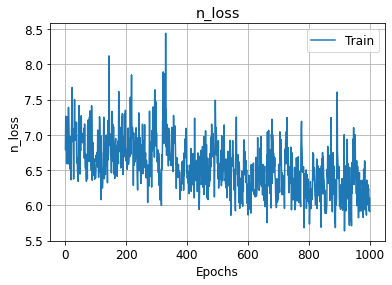

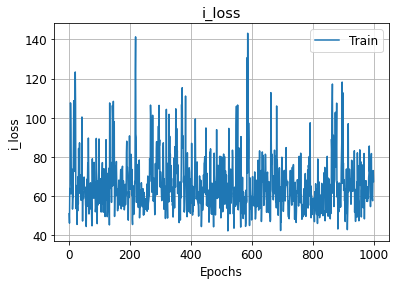

In [245]:
plot_performance(history=diffuser_history, epochs=1000, metric='n_loss')
plot_performance(history=diffuser_history, epochs=1000, metric='i_loss')

Encoded:


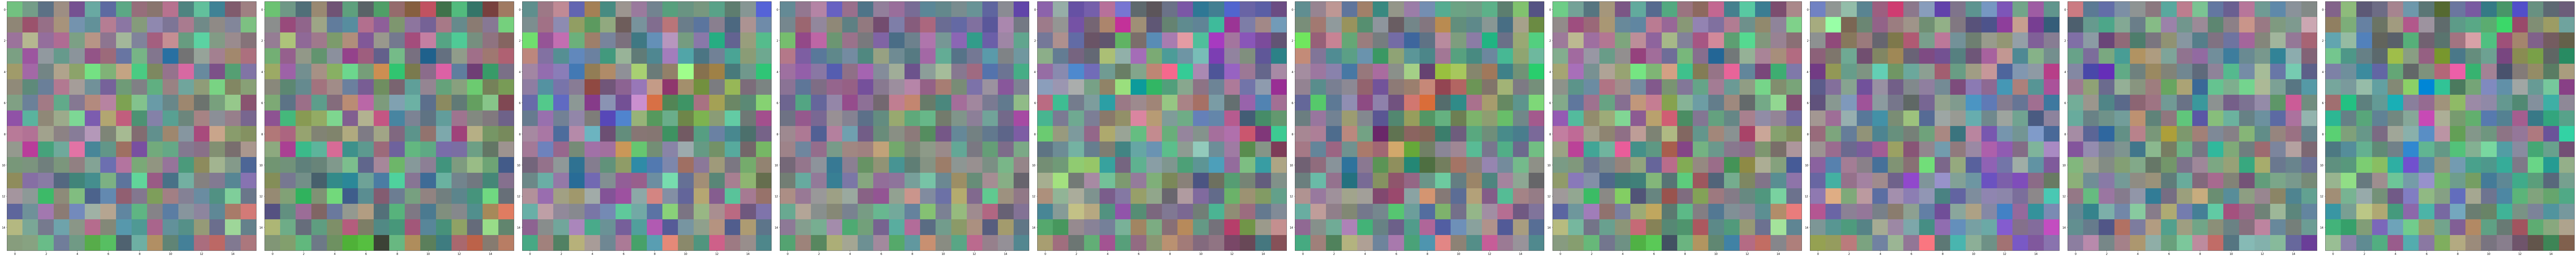

Decoded:


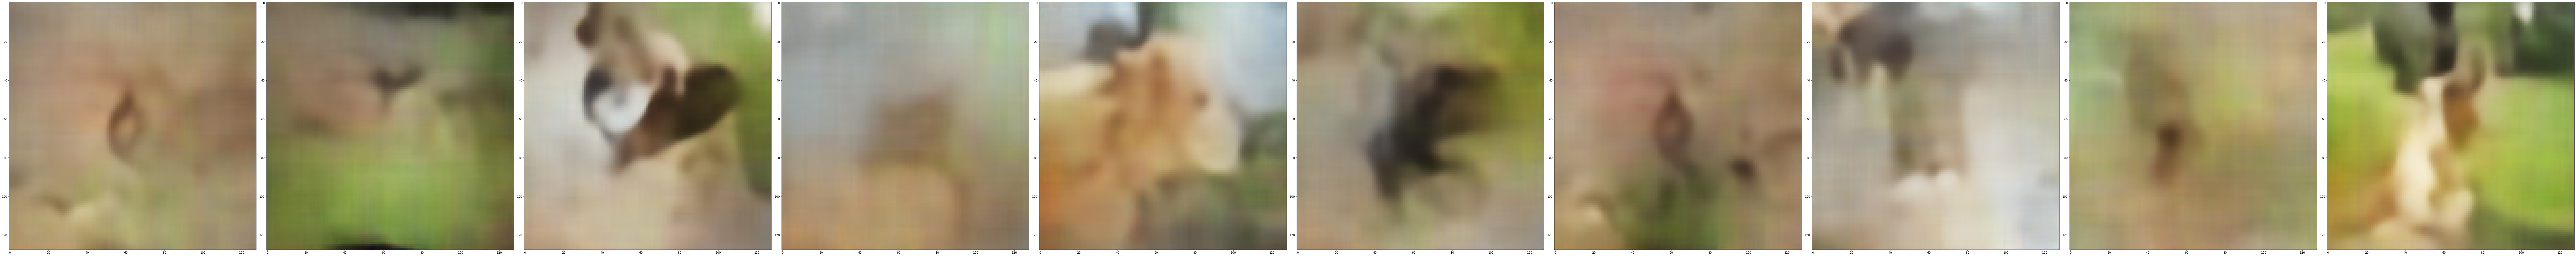

In [240]:
print('Encoded:')
generated_latents = model.generate(10, 20)
display_latents = generated_latents.numpy()
display_latents -= np.min(display_latents)
display_latents /= np.max(display_latents)
plot_images(display_latents)

print('Decoded:')
generated_images = vae.decode(generated_latents)
plot_images(generated_images.numpy())